In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import baltic as bt
import pickle
import matplotlib as mpl
import matplotlib.patheffects as path_effects
import seaborn as sns
import pandas as pd
%matplotlib inline

import matplotlib.patches as mpatches

In [2]:
tree_file = '../data/trees/titered_annotated_tree.nexus'
tree = bt.loadNexus(tree_file, absoluteTime=False)

colors = pickle.load(open('./colors.p', 'rb'))

In [3]:
def label_mrcas(tree):
    serotypes = ['DENV1', 'DENV2', 'DENV3', 'DENV4']
    
    for serotype in serotypes:
        serotype_tips = [k.numName for k in tree.leaves if k.numName.startswith(serotype)]

        mrca = sorted([node for node in tree.nodes 
                       if all([l in node.leaves for l in serotype_tips])], 
                     key = lambda n: node.height)[-1]
        mrca.traits['mrca'] = serotype
    
label_mrcas(tree)

In [4]:
def plot_tree(tree, ax, serotype, cmap, vmax):
    branchWidth=2 ## default branch width
    ll = tree
    plt.yticks(size=0)
    
    for k in ll.Objects: ## iterate over objects in tree
        x=k.x ## or use absolute time instead
        y=k.y*1.5 ## get y position from .drawTree that was run earlier, but could be anything else

        xp=k.parent.x ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x
            
        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
            c = cmap(k.traits['%s_vaccine_dTiter'%serotype]/vmax)
            s=50 ## tip size can be fixed
            
            if 'DELTA30' in k.numName and serotype in k.numName:
                plt.plot([x,tree.treeHeight], [y,y], color='darkgray', linestyle=':')
                marker = plt.text(tree.treeHeight,y,'x', fontsize=20,va='center', ha='left', fontweight='bold', fontname='courier', zorder=10000)
                marker.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'),
                       path_effects.Normal()])
            else:
#                 plt.text(x*1.05, y, k.numName, fontsize=9, va='center')
                plt.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
                plt.scatter(x,y,s=s+0.8*s,facecolor='darkgray',edgecolor='none',zorder=10) ## plot black circle underneath
                        
        elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
            plt.plot([x,x],[k.children[-1].y*1.5,k.children[0].y*1.5],lw=branchWidth,color='darkgray',ls='-',zorder=9)
            if 'mrca' in k.traits:
                ax.text((xp+x)/2., y+0.5, k.traits['mrca'])
            

        plt.plot([xp,x],[y,y],lw=branchWidth,color='darkgray',ls='-',zorder=9)

        
    ax.spines['top'].set_visible(False) ## no axes
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    if sero in ['DENV3', 'DENV4']:
        ax.set_xlabel('Substitutions per site')
    else:
        ax.spines['bottom'].set_visible(False)
#     x0,x1 = plt.xlim()
#     plt.xlim((x0, x1*1.1))

/Users/Sidney/Library/Python/2.7/lib/python/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "
/Users/Sidney/Library/Python/2.7/lib/python/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'courier'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


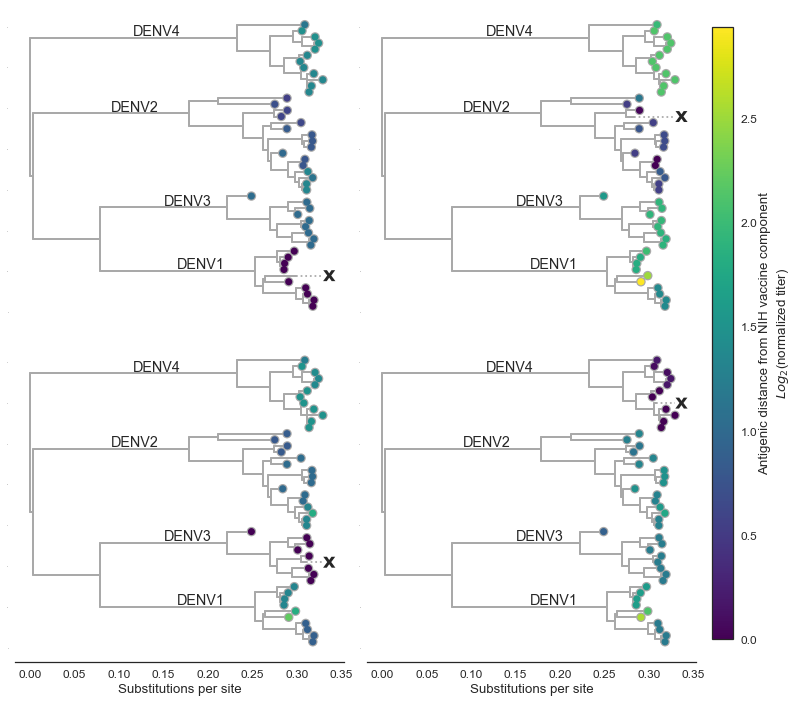

In [5]:
sns.set(style='white', font_scale=1.2)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10), sharex=True) 

serotypes = ['DENV1', 'DENV2', 'DENV3', 'DENV4']
max_dTiter = 0.
for s in serotypes:
    max_dTiter = max(max_dTiter, max([k.traits['%s_vaccine_dTiter'%s] for k in tree.leaves]))

for ax, sero in zip(axes.flatten().flatten(), serotypes):
    plt.sca(ax)
    plot_tree(tree, ax, sero, plt.cm.viridis, max_dTiter)
    
cbar_ax = fig.add_axes([1.,0.1,0.03,0.85])
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0., vmax=max_dTiter)
cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,
                                norm=norm,
                                orientation='vertical', 
                                label='Antigenic distance from NIH vaccine component\n'+r'$Log_2$(normalized titer)')

plt.tight_layout()
plt.savefig('./png/vaccine_titer_trees.png', dpi=300, bbox_inches='tight')